#### This notebook trains our baseline model

Imports

In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
os.chdir("../models")
from model import CustomCNN
from common_utils import set_seed, EarlyStopper, train, get_mean_rgb, CustomTransform

# set seed
set_seed(42)

Initialise model and dataset

In [2]:
model = CustomCNN() # initialise model

mean_rgb = get_mean_rgb(datasets.Flowers102(root='../data', split='test', download=True, transform=transforms.ToTensor())) # get mean rgb values of dataset
transform = CustomTransform(mean_rgb) # initialise transform

# load data
train_dataset = datasets.Flowers102(root='../data', split='test', download=True, transform=transform) 
val_dataset = datasets.Flowers102(root='../data', split='val', download=True, transform=transform) 
test_dataset = datasets.Flowers102(root='../data', split='train', download=True, transform=transform)
# NOTE: Due to a bug with the Flowers102 dataset, the train and test splits are swapped

batch_size = 8
# initialise dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Specify hyperparameters

In [3]:
if torch.cuda.is_available(): # nvidia gpu
    device = torch.device("cuda")
elif torch.backends.mps.is_available(): # apple gpu
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=0.001) # initialise optimiser
loss = nn.CrossEntropyLoss() # initialise loss function

epochs = 300 # number of epochs
early_stopper = EarlyStopper(patience=25) # initialise early stopper


# Make directory to save baseline model
baseline_model_path = "./saved_models/baseline_model"
if not os.path.exists(baseline_model_path):
    os.mkdir(baseline_model_path)

# Define the device-specific path
device_type = None
if device == torch.device("cuda"):
    device_type = "cuda"
elif device == torch.device("mps"):
    device_type = "mps"
else:
    device_type = "cpu"

# Construct the full path
device_path = os.path.join(baseline_model_path, device_type)

# Create the directory if it doesn't exist
if not os.path.exists(device_path):
    os.mkdir(device_path)

Train the model

In [4]:
train_loss_list, val_loss_list, val_acc_list = train(model, train_dataloader, val_dataloader, optimiser, loss, device, epochs, early_stopper, device_path) # train model

Epoch 1/300:   0%|          | 0/769 [00:00<?, ?it/s]/Users/adrian/miniconda3/envs/sc4001/lib/python3.8/site-packages/torch/nn/functional.py:2563: UserWarning: The operator 'aten::avg_pool3d.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  div = avg_pool3d(div, (size, 1, 1), stride=1).squeeze(1)
Epoch 1/300:  14%|█▍        | 109/769 [00:32<03:31,  3.12it/s, Training loss=4.5619]

Plot train, test loss and test accuracy

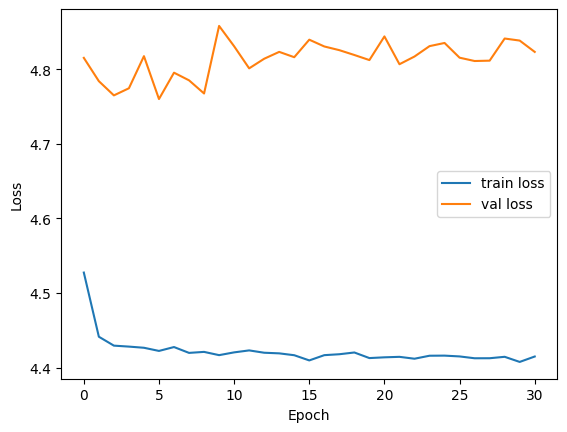

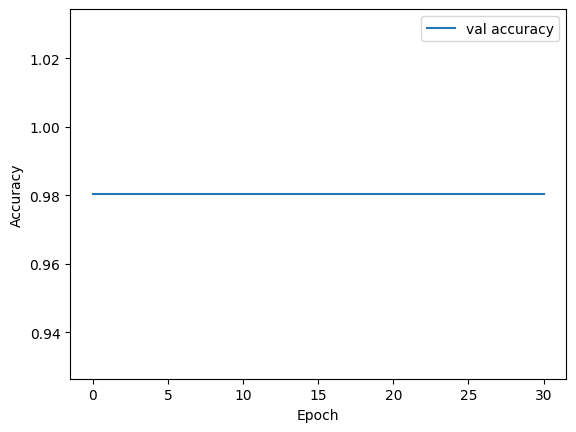

In [ ]:
# plot the graphs
import matplotlib.pyplot as plt
plt.plot(train_loss_list, label="train loss")
plt.plot(val_loss_list, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(val_acc_list, label="val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()